# Retail Analytics — Analysis Notebook
This notebook connects to the SQLite database, runs KPI queries, and generates clean charts saved to `/dashboards` + CSVs to `/data/processed`.

In [7]:
import sqlite3
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Détecte la racine du projet (le notebook est dans /notebooks)
BASE = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DB_PATH = BASE / "retail.db"

# Crée/charge la base si besoin
if not DB_PATH.exists():
    import subprocess, sys
    subprocess.run([sys.executable, str(BASE / "src" / "setup_db.py")], check=True)

conn = sqlite3.connect(DB_PATH.as_posix())
print("BASE =", BASE)b

BASE = C:\Users\Dylan\Desktop\Coursera\retail-analytics-sql-python


In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({
    "figure.figsize": (8,4),
    "axes.grid": True,
    "grid.alpha": .25,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.titlesize": 12,
    "axes.titleweight": "semibold",
    "axes.labelsize": 10,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

In [8]:
sql_text = (BASE / "sql" / "03_kpi_queries.sql").read_text(encoding="utf-8")
# Découpe grossière par ';' et nettoie
queries = [q.strip() + ";" for q in sql_text.split(";") if q.strip()]
len(queries), queries[0][:80]  # contrôle visuel

(5,
 '-- 03_kpi_queries.sql\n\n-- 1) Monthly revenue\nWITH order_revenue AS (\n  SELECT\n  ')

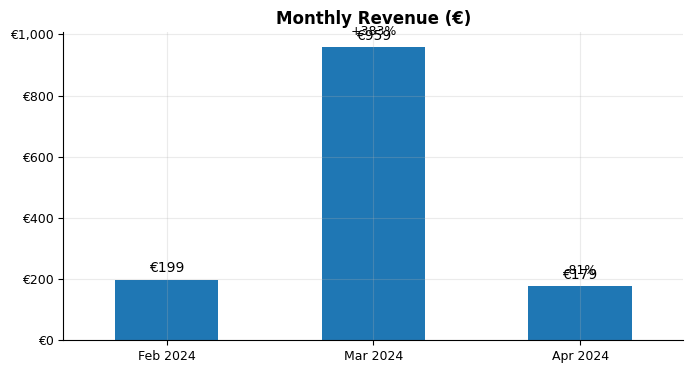

In [12]:
import matplotlib.ticker as mtick
import pandas as pd

q1 = open(BASE / "sql" / "03_kpi_queries.sql","r",encoding="utf-8").read().split(";")[0] + ";"
rev = pd.read_sql_query(q1, conn, parse_dates=["month"]).sort_values("month")
rev["label"] = rev["month"].dt.strftime("%b %Y")           # ex: Feb 2024
rev["mom"] = rev["total_revenue"].pct_change()             # croissance MoM

ax = rev.plot(kind="bar", x="label", y="total_revenue", rot=0, legend=False,
              title="Monthly Revenue (€)")
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('€{x:,.0f}'))

# labels sur les barres
ax.bar_label(ax.containers[0], fmt='€{:.0f}', padding=3)

# % MoM au-dessus des barres (sauf la 1ère)
for i, (lab, mom, val) in enumerate(zip(rev["label"], rev["mom"], rev["total_revenue"])):
    if i == 0 or pd.isna(mom): 
        continue
    ax.text(i, val + max(rev["total_revenue"])*0.03, f"{mom:+.0%}", ha="center", va="bottom", fontsize=9)

ax.set_xlabel("")  # plus propre
ax.figure.savefig(BASE / "dashboards" / "monthly_revenue.png", dpi=220, bbox_inches="tight")
plt.show()

rev.drop(columns=["label"]).to_csv(BASE / "data" / "processed" / "monthly_revenue.csv", index=False)

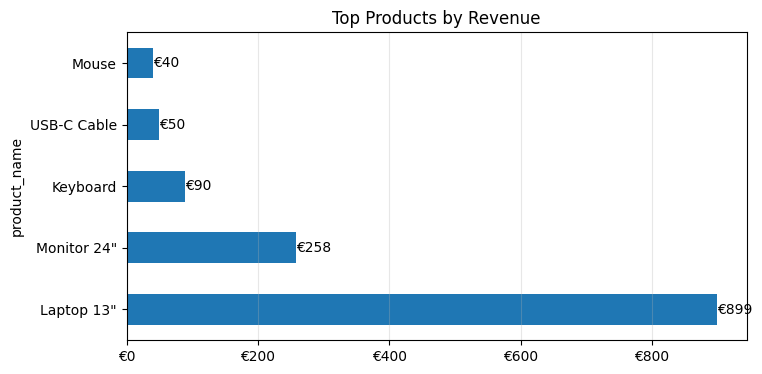

,product_name,revenue
0,"Laptop 13""",899.0
1,"Monitor 24""",258.0
2,Keyboard,89.7
3,USB-C Cable,49.5
4,Mouse,39.8


In [10]:
top = pd.read_sql_query(queries[1], conn)
ax = top.plot(kind="barh", x="product_name", y="revenue", title="Top Products by Revenue", legend=False)
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('€{x:,.0f}'))
ax.grid(axis="x", alpha=.3)
ax.figure.set_size_inches(8,4)
ax.bar_label(ax.containers[0], fmt='€{:.0f}')
ax.figure.savefig(BASE / "dashboards" / "top_products.png", dpi=220, bbox_inches="tight")
plt.show()
top.to_csv(BASE / "data" / "processed" / "top_products.csv", index=False)
top